In [ ]:
# %pip install matplotlib numpy pandas pytorch-lightning seaborn scipy torch torchvision wandb

In [1]:
import os
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
from torch import nn
from tqdm import tqdm

import config

# Model

Write the `create_linear_layer` function. 

This function initializes a linear layer (`torch.nn.Linear`) with weights and optional biases drawn from a symmetric uniform distribution between `[-\sqrt(3/in_features), \sqrt(3/in_features)]`. 

Don't forget If `bias` is `True`, initialize the bias using the same distribution. To initialize a parameter use the `nn.Parameter()` function.

In [2]:
def create_linear_layer(
    in_features: int, out_features: int, bias: bool = True
) -> nn.Linear:
    """Initialize one linear layer with a symmetric uniform distribution on
    [-sqrt(3/in_features), sqrt(3/in_features)]

    :param in_features: size of the input to the layer
    :param out_features: size of the output of the layer
    :param bias: whether to include a bias
    :return:
    """
    layer = nn.Linear(...)
    # TODO
    return layer

We have implemented the `FullResNet` model class to represent $\texttt{res-3}$ using the following equation:

$$
h_{k+1} = h_k + \alpha_L V_{k+1}\text{ReLU}(W_{k+1}h_k)
$$

Here are the key components of the implementation:

- `self.scaling_weight` corresponds to $\alpha_L$.
- `self.init` and `self.final` represent the $A$ and $B$ matrices in Equation 2.1. We initialize these matrices using a uniform initialization method with `create_linear_layer()`.

Since we need to obtain separate values for $h_0$ and $h_L$, we have defined two different forward functions:

- $h_0$ is equivalent to the result of `self.init()`.
- $h_L$ can be obtained by calling `self.forward_hidden_state()`. It simulates the operation described by $h_{k+1} = h_k + \alpha_L V_{k+1}\text{ReLU}(W_{k+1}h_k)$, where:
  - `self.inner_weights` corresponds to $W_{k+1}$, and each $W_{i}$ is created using `create_linear_layer()`.
  - `self.outer_weights` corresponds to $V_{k+1}$, and each $V_{i}$ is created using `create_linear_layer()`.

We have intentionally left the full `forward()` function for your understanding and further implementation.


In [3]:
class FullResNet(pl.LightningModule):
    def __init__(self, first_coord: int, final_width: int, **model_config: dict):
        """Residual neural network, subclass of ResNet where the weights can
        be initialized as discretizations of stochastic processes and where we
        add a matrix multiplication in the update function, compared to
        SimpleResNet (called 'res-3' in the paper).

        :param first_coord: size of the input data
        :param final_width: size of the output
        :param model_config: configuration dictionary with hyperparameters
        """
        super().__init__()

        self.initial_width = first_coord
        self.final_width = final_width
        self.model_config = model_config
        self.width = model_config["width"]
        self.depth = model_config["depth"]
        self.activation = getattr(nn, model_config["activation"])()
        self.loss = nn.CrossEntropyLoss()

        # TODO
        self.scaling_weight = ...

        # Uniform initialization on [-sqrt(3/width), sqrt(3/width)]
        self.init = ...
        self.final = ...

        self.inner_weights = ...
        self.outer_weights = ...

    def forward_hidden_state(self, hidden_state: torch.Tensor) -> torch.Tensor:
        """Function that outputs the last hidden state, useful to compare norms

        :param hidden_state: output of the initial layer
        :return: output of the last hidden layer
        """
        for k in range(self.depth):
            hidden_state = ...
        return hidden_state

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        hidden_state = self.init(x)
        hidden_state = self.forward_hidden_state(hidden_state)
        return self.final(hidden_state)

# Experiment

Time to run the experiment! Develop the `run_experiment()` function which will gather data to generate the course figures. We need to plot three graphs, each corresponding to different values of $\beta$ listed in `grid_scaling`. For every graph, we aim to record various initial hidden state norms across different network lengths $L$, which will form the x-axis of each graph. These $L$ values are found in the `grid_depth` list. For every length, repeat the initialization experiment `config["niter"]` times.

Collect the results in a dictionary with the following keys:
* `"depth"`: Referring to the network depth $L$.
* `"scaling"`: Corresponding to the $\beta$ values from `grid_scaling`.
* `"hidden_state_ratio"`: Calculated as $ \left\| h_L \right\| / \left\| h_0 \right\| $.
* `"hidden_state_difference"`: Calculated as $ \left\| h_L - h_0 \right\| / \left\| h_0 \right\| $.
* `"gradient_ratio"`: Representing $ \left\| \frac{\partial \mathscr{L}}{\partial h_0} \right\| / \left\| \frac{\partial \mathscr{L}}{\partial h_L} \right\| $.
* `"gradient_difference"`: Representing $ \left\| \frac{\partial \mathscr{L}}{\partial h_L} - \frac{\partial \mathscr{L}}{\partial h_0}  \right\| / \left\| \frac{\partial \mathscr{L}}{\partial h_L} \right\| $

In [4]:
def run_experiment(config: dict, grid_scaling: list, grid_depth: list) -> list:
    """Loop over a grid of depths and scaling values, compare the norm of the
    last layer values to the initial one, as well as their respective
    gradients.

    :param config: configuration of the experiment
    :param grid_scaling: all values of scaling to loop over
    :param grid_depth: all depths of the ResNet to loop over
    :return:
    """
    results = []
    for scaling in grid_scaling:
        print(f"Experiment for scaling={scaling}")
        total_iterations = len(grid_depth) * config["niter"]
        progress_bar = tqdm(total=total_iterations, desc="Overall Progress")
        for depth in grid_depth:
            for k in range(config["niter"]):
                if config["niter"] > 10**3 and k % 10 == 0:
                    progress_bar.set_description(
                        f"Depth: {depth}, Iteration: {k}/{config['niter']}"
                    )
                progress_bar.update(1)
                model_config = config["model-config"]
                model_config["scaling"] = scaling
                model_config["depth"] = depth

                x0 = torch.rand((1, config["dim_input"]))
                target = torch.rand((1,))
                model = FullResNet(
                    config["dim_input"], config["nb_classes"], **model_config
                )

                h_0 = ...
                h_L = ...
                output = ...

                h_0.retain_grad()
                h_L.retain_grad()

                # model.train()
                loss = torch.norm(output - target) ** 2
                loss.backward()

                h_0_grad = h_0.grad
                h_L_grad = h_L.grad

                results.append(
                    {
                        "depth": depth,
                        "scaling": scaling,
                        "hidden_state_ratio": float(...),
                        "hidden_state_difference": float(...),
                        "gradient_ratio": float(...),
                        "gradient_difference": float(...),
                    }
                )
            progress_bar.set_description(f"Depth: {depth}")
        progress_bar.close()
    return results

# Running the experiments

In [5]:
config_iid = config.scaling_initialization_exp_iid

grid_depth = np.linspace(
    10, 1000, num=10, dtype=int
)  # Variation of L : the length of the network
grid_scaling = [1.0, 0.25, 0.5]  # Grid for \Beta

results_iid = run_experiment(config_iid, grid_scaling, grid_depth)

Experiment for scaling=1.0


Depth: 1000: 100%|██████████| 500/500 [01:53<00:00,  4.42it/s]     


Experiment for scaling=0.25


Depth: 1000: 100%|██████████| 500/500 [01:55<00:00,  4.31it/s]     


Experiment for scaling=0.5


Depth: 1000: 100%|██████████| 500/500 [01:55<00:00,  4.33it/s]     


Here is a premade plotting function

In [24]:
def plot_results(results: list, col_order: list, filepath: Optional[str] = "figures"):
    """Plot relative ratios between last and first hidden state norms and gradient norms,
    as a function of the depth L.
    See Figures 1, 3, 4, 5 of the paper.

    :param results: list of results
    :param col_order: grid of scaling values for plotting
    :param filepath: path to the folder where the figures should be saved
    :return:
    """
    df = pd.DataFrame(results)
    df.columns = [
        "depth",
        r"$\beta$",
        "hidden_state_ratio",
        "hidden_state_difference",
        "gradient_ratio",
        "gradient_difference",
    ]

    g = sns.relplot(
        x="depth",
        y="hidden_state_difference",
        col=r"$\beta$",
        col_wrap=3,
        col_order=col_order,
        data=df,
        kind="line",
        facet_kws=dict(sharey=False),
    )

    g.axes[0].set_ylabel("")
    g.axes[0].set_xlabel(r"$L$")
    g.axes[1].set_xlabel(r"$L$")
    g.axes[2].set_xlabel(r"$L$")
    plt.savefig(
        os.path.join(filepath, "norm_output_initialization.pdf"), bbox_inches="tight"
    )
    g.fig.subplots_adjust(top=0.85)  # adjust the Figure in rp
    g.fig.suptitle(r"$\left\| h_L \right\| / \left\| h_0 \right\|$")
    plt.show()

    g = sns.relplot(
        x="depth",
        y="gradient_difference",
        col=r"$\beta$",
        col_wrap=3,
        col_order=col_order,
        data=df,
        kind="line",
        facet_kws=dict(sharey=False),
    )

    g.axes[0].set_ylabel("")
    g.axes[0].set_xlabel(r"$L$")
    g.axes[1].set_xlabel(r"$L$")
    g.axes[2].set_xlabel(r"$L$")
    plt.savefig(
        os.path.join(filepath, "norm_gradient_initialization.pdf"), bbox_inches="tight"
    )
    g.fig.subplots_adjust(top=0.85)  # adjust the Figure in rp
    g.fig.suptitle(
        r"$ \left\| \frac{\partial \mathscr{L}}{\partial h_L} - \frac{\partial \mathscr{L}}{\partial h_0}  \right\| / \left\| \frac{\partial \mathscr{L}}{\partial h_L} \right\| $"
    )
    plt.show()

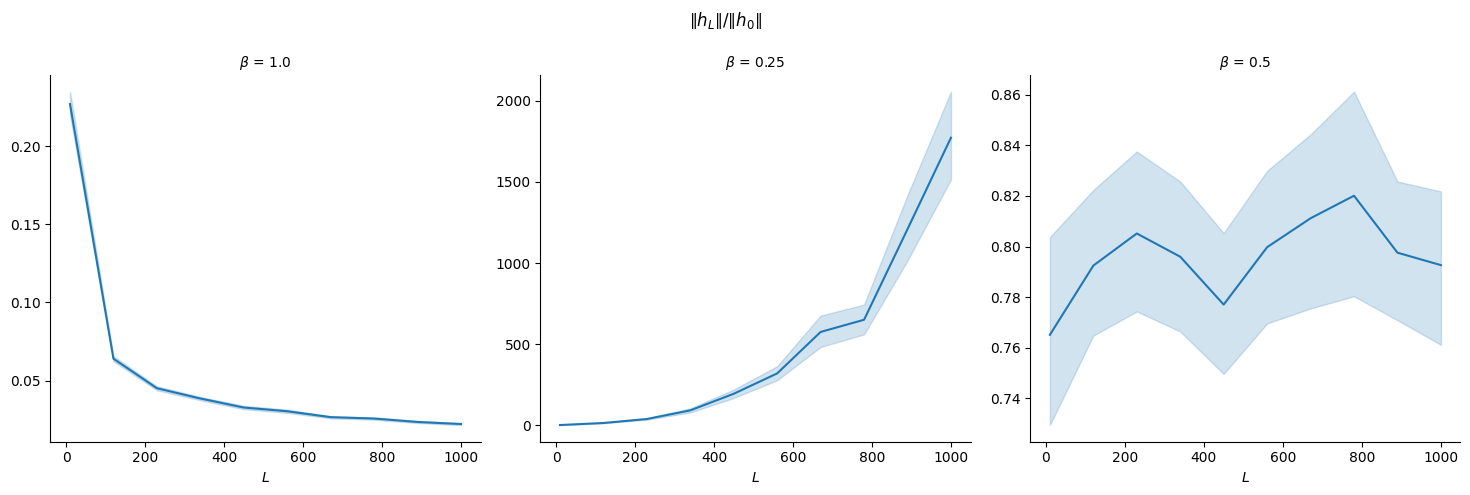

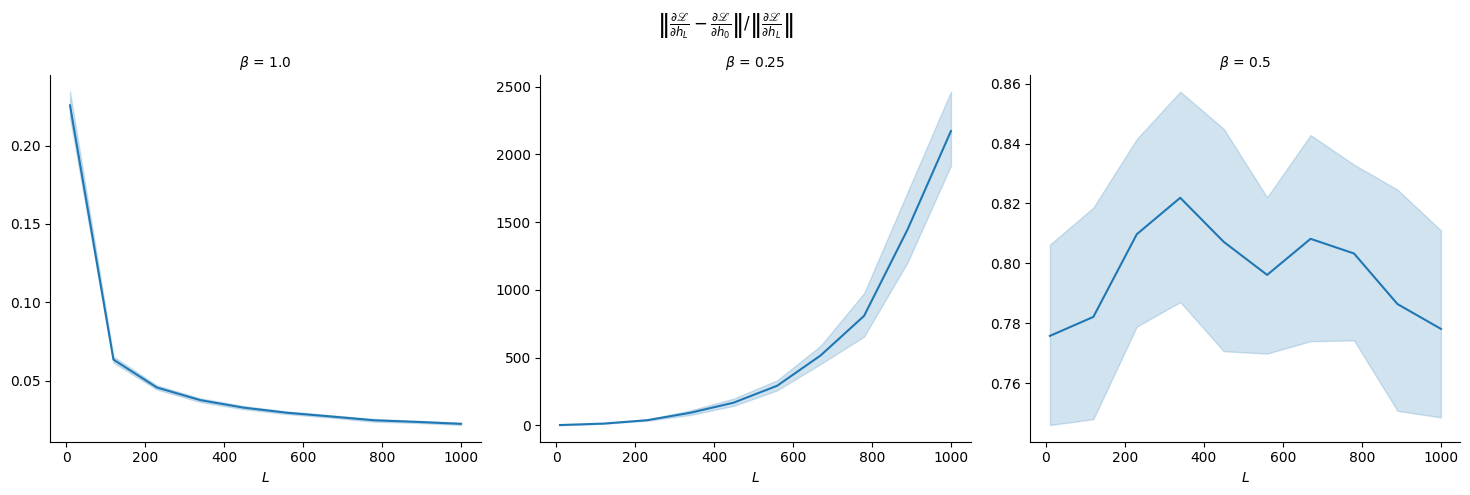

In [25]:
filepath = "figures/scaling_initialization/iid"
os.makedirs(filepath, exist_ok=True)
plot_results(results_iid, grid_scaling, filepath)